## DATA IMPORT

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

train_data = pd.read_csv('data/train.csv')
print('Training data set: ' + str(len(train_data)))

#train_data.head()

Training data set: 1306122


## DATA WRANGLING

In [26]:
%%time

import contractions
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
#nltk.download()
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 
from nltk.corpus import  wordnet
from nltk.corpus import stopwords 
from joblib import dump
from joblib import load

stop_words = set(stopwords.words('english'))

def remove_non_ascii(text):
    return ''.join(i for i in text if ord(i)<128)

def remove_white_space(text):
    return text.strip().strip('\t\n')

def remove_special_character(text):
    return re.sub('[^A-Za-z0-9\s]+', '', text)

def porter_stemmer(text): #PorterStemmer
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in word_tokenize(text)])
    return text

def lemmatizer(text): 
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)])
    return text

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
    
def remove_stop_word(text): 
    text = ' '.join([w for w in nltk.word_tokenize(text) if w not in stop_words])
    return text

train_data['origin'] = train_data['question_text']
train_data['question_text'] = train_data['question_text'].str.normalize('NFKD')\
.apply(remove_non_ascii).apply(remove_white_space).apply(contractions.fix).str.lower()\
.apply(remove_special_character).apply(remove_stop_word)

train_data['question_text_stem'] = train_data['question_text'].apply(porter_stemmer)
train_data['question_text_lemma'] = train_data['question_text'].apply(lemmatizer)
train_data['word_count'] = train_data['question_text'].apply(lambda x: len(str(x).split()))
train_data = train_data.loc[(train_data.word_count > 0)]
train_data= train_data.reset_index()

print('Training data set: ' + str(len(train_data)))
#print(train_data.head())

filename = 'data/train_data.sav'
dump(train_data, filename)

[nltk_data] Downloading package punkt to /Users/yang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Training data set: 1306020
CPU times: user 30min 52s, sys: 1min 29s, total: 32min 21s
Wall time: 2h 39min 25s


## WORD CLOUD 

Just for fun, from <B>[Generating WordClouds in Python](https://www.datacamp.com/community/tutorials/wordcloud-python)</B>

In [27]:
from joblib import dump
from joblib import load
filename = 'data/train_data.sav'
train_data = load(filename)
print('Training data set: ' + str(len(train_data)))

Training data set: 1306020


In [28]:
#?WordCloud

In [ ]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

#train_data[["question_text", "question_text_stem","question_text_lemma"]].head()

text = " ".join(question for question in train_data.question_text_lemma)
plt.figure(figsize=(20,20))
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("image/all_words.png")

In [ ]:
text = " ".join(question for question in train_data.loc[train_data.target == 0,'question_text_lemma'])
plt.figure(figsize=(20,20))
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("image/positive_words.png")

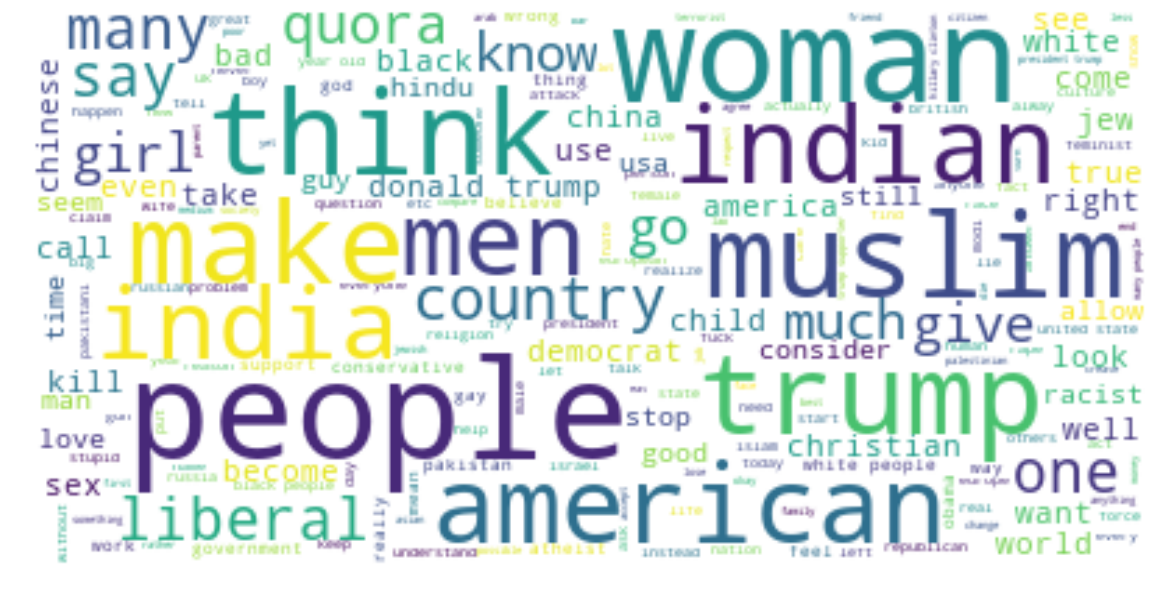

In [82]:
text = " ".join(question for question in train_data.loc[train_data.target == 1,'question_text_lemma'])
plt.figure(figsize=(20,20))
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("image/negative_words.png")

## TRAIN-TEST DATA PREPARATOIN 

In [38]:
%%time

from joblib import dump
from joblib import load

train_text_lemma = train_data['question_text_lemma']
train_text_stem = train_data['question_text_stem']
train_target = train_data['target']
filename = 'data/target.sav'
dump(train_target, filename)

filename = 'data/question_text_lemma.sav'
dump(train_text_lemma, filename)

filename = 'data/question_text_stem.sav'
dump(train_text_stem, filename)


CPU times: user 1.39 s, sys: 560 ms, total: 1.95 s
Wall time: 2.35 s


In [60]:
%%time

#split dataset tf-idf & count for final test & validation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# control parameter
t_size = 0.35

X_lemma_train, X_lemma_hold, y_lemma_train, y_lemma_hold  = train_test_split(train_text_lemma, train_target, train_size=t_size, random_state=42, stratify=train_target)
X_stem_train, X_stem_hold, y_stem_train, y_stem_hold  = train_test_split(train_text_stem, train_target, train_size=t_size, random_state=42, stratify=train_target)

count_vectorizer_lemma = CountVectorizer()
X_lemma_train_c = count_vectorizer_lemma.fit_transform(X_lemma_train)
X_lemma_hold_c = count_vectorizer_lemma.transform(X_lemma_hold)

# count_vectorizer_stem = CountVectorizer()
# X_stem_train_c = count_vectorizer_stem.fit_transform(X_stem_train)
# X_stem_hold_c = count_vectorizer_stem.transform(X_stem_hold)


tfidf_vectorizer_lemma = TfidfVectorizer()
X_lemma_train_t= tfidf_vectorizer_lemma.fit_transform(X_lemma_train)
X_lemma_hold_t= tfidf_vectorizer_lemma.transform(X_lemma_hold)

# tfidf_vectorizer_stem = TfidfVectorizer()
# X_stem_train_t= tfidf_vectorizer_stem.fit_transform(X_stem_train)
# X_stem_hold_t= tfidf_vectorizer_stem.transform(X_stem_hold)


CPU times: user 23.4 s, sys: 437 ms, total: 23.8 s
Wall time: 22.1 s


## Bag Of Words Using Traiditonal Machine Learning 

In [61]:
model_compare= {} # to store different accuracy result

In [ ]:
#def for training

In [ ]:
#def for report

### Grid Search for Algorithm (BernoulliNB)

In [79]:
%%time

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np

X_train, X_test, y_train, y_test  = train_test_split(X_lemma_train, y_lemma_train, test_size=0.30, random_state=42, stratify=y_lemma_train)
vectorizer = CountVectorizer()
X_train= vectorizer.fit_transform(X_train)
X_test= vectorizer.transform(X_test)

param_grid = {'alpha': np.arange(0.2, 2.5, 0.3), 'fit_prior':['True','False']}

estimator = BernoulliNB()
search = GridSearchCV(estimator, param_grid, cv=5)
search.fit(X_train,y_train)


CPU times: user 39.6 s, sys: 2.59 s, total: 42.2 s
Wall time: 13.4 s


BernoulliNB(alpha=1.4, binarize=0.0, class_prior=None, fit_prior='True')


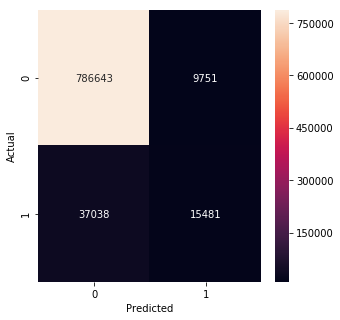

              precision    recall  f1-score   support

     Sincere       0.96      0.99      0.97    796394
   Insincere       0.61      0.29      0.40     52519

    accuracy                           0.94    848913
   macro avg       0.78      0.64      0.68    848913
weighted avg       0.93      0.94      0.94    848913

auc score:  0.07503717162462376 0.9249628283753761


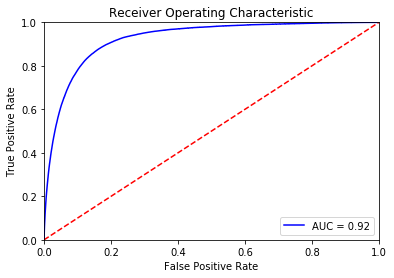

In [81]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from joblib import dump
from joblib import load

# the best naive
best= search.best_estimator_ 
best.fit(X_train,y_train)

target_names = ['Sincere', 'Insincere']
print(best)
train_predicted = best.predict(X_train)
test_predicted = best.predict(X_test)
train_report = classification_report(y_train,train_predicted, target_names=target_names)
test_report = classification_report(y_test,test_predicted, target_names=target_names)
conf_train = confusion_matrix(y_train,train_predicted)
conf_test = confusion_matrix(y_test,test_predicted)

best.fit(X_lemma_train_c,y_lemma_train)
all_predicted = best.predict(X_lemma_hold_c)
all_report = classification_report(y_lemma_hold, all_predicted, target_names=target_names)
conf_all = confusion_matrix(y_lemma_hold, all_predicted)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_all, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

model_compare['BernoulliNB'] =all_report
print(all_report)

filename = 'data/naive.sav'
dump(best, filename)
best = load(filename)


probs = best.predict_proba(X_lemma_hold_c)
preds_1 = probs[:,1]
auc_1 =  roc_auc_score(y_lemma_hold, preds_1)
preds_0 = probs[:,0]
auc_0 =  roc_auc_score(y_lemma_hold, preds_0)
print("auc score: ", auc_0, auc_1)

fpr, tpr, threshold = metrics.roc_curve(y_lemma_hold, preds_1)
roc_auc = metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Grid Search for Algorithm (Logistic Regression)

In [ ]:
%%time

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
from joblib import dump
from joblib import load


# X_lemma_train  y_lemma_train
# full model split: X_lemma_train_t & X_lemma_hold_t / y_lemma_train & y_lemma_hold

X_train, X_test, y_train, y_test  = train_test_split(X_lemma_train, y_lemma_train, test_size=0.30, random_state=42, stratify=y_lemma_train)
tfidf_vectorizer = TfidfVectorizer()
X_train= tfidf_vectorizer.fit_transform(X_train)
X_test= tfidf_vectorizer.transform(X_test)

param_grid = {'alpha': np.arange(0.2, 2.5, 0.3), 'fit_prior':['True','False']}

estimator = BernoulliNB()
search = GridSearchCV(estimator, param_grid, cv=5)
search.fit(X_train,y_train)

# the best naive
best_naive = search.best_estimator_ 
best_naive.fit(X_train,y_train)

target_names = ['Sincere', 'Insincere']
print(best_naive)
train_predicted = best_naive.predict(X_train)
test_predicted = best_naive.predict(X_test)
train_report = classification_report(y_train,train_predicted, target_names=target_names)
test_report = classification_report(y_test,test_predicted, target_names=target_names)
model_compare['BernoulliNB_train'] =train_report
model_compare['BernoulliNB_test'] =test_report
print(train_report)
print('\n')
print(test_report)
print('\n')

best_naive.fit(X_lemma_train_t,y_lemma_train)
all_predicted = best_naive.predict(X_lemma_hold_t)
all_report = classification_report(y_lemma_hold, all_predicted, target_names=target_names)
model_compare['BernoulliNB_all'] =all_report
print(all_report)

filename = 'data/naive.sav'
dump(best_naive, filename)
best_naive = load(filename)

# X_lemma_train  y_lemma_train
# full model split: X_lemma_train_t & X_lemma_hold_t / y_lemma_train & y_lemma_hold

X_train, X_test, y_train, y_test  = train_test_split(X_lemma_train, y_lemma_train, test_size=0.30, random_state=42, stratify=y_lemma_train)
vectorizer = CountVectorizer()
X_train= vectorizer.fit_transform(X_train)
X_test= vectorizer.transform(X_test)

param_grid = {'alpha': np.arange(0.2, 2.5, 0.3), 'fit_prior':['True','False']}

estimator = BernoulliNB()
search = GridSearchCV(estimator, param_grid, cv=5)
search.fit(X_train,y_train)

# the best naive
best_naive = search.best_estimator_ 
best_naive.fit(X_train,y_train)

target_names = ['Sincere', 'Insincere']
print(best_naive)
train_predicted = best_naive.predict(X_train)
test_predicted = best_naive.predict(X_test)
train_report = classification_report(y_train,train_predicted, target_names=target_names)
test_report = classification_report(y_test,test_predicted, target_names=target_names)
conf_train = confusion_matrix(y_train,train_predicted)
conf_test = confusion_matrix(y_test,test_predicted)

print(conf_train)
print('\n')

model_compare['BernoulliNB_train_c'] =train_report
model_compare['BernoulliNB_test_c'] =test_report
print(train_report)
print('\n')
print(test_report)
print('\n')

best_naive.fit(X_lemma_train_c,y_lemma_train)
all_predicted = best_naive.predict(X_lemma_hold_c)
all_report = classification_report(y_lemma_hold, all_predicted, target_names=target_names)
conf_all = confusion_matrix(y_lemma_hold, all_predicted)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_all, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

model_compare['BernoulliNB_all_c'] =all_report
print(all_report)

filename = 'data/naive.sav'
dump(best_naive, filename)
best_naive = load(filename)

### Grid Search for Algorithm (SVM)

### Grid Search for Algorithm (RandomForestClassifier)

### Grid Search for Algorithm (GradientBoostingClassifier)

## Classification Result Comparsion

In [ ]:
for key in model_compare:
    print(key)
    print(model_compare[key])